# Functional analysis: PROGENy / DoRothEA / CytoSig


To facilitate the interpretation of scRNA-seq gene expression readouts and their differences across conditions we can summarize the information
and infer pathway activities from prior knowledge.

In this notebook we use `decoupler` {cite}`Badia-i-Mompel2022` a tool that contains different statistical methods to extract biological activities from omics data using prior knowledge.
We run the method on the results from the differential gene expression analysis that compared scRNAseq data from LUAD and LUSC using celltype specific
pseudo-bulk data.

We infer activities of the following types:

* Pathways from PROGENy {cite}`Schubert2018`
* Transcription factors from DoRothEA {cite}`Garcia-Alonso2019`
* Molecular Signatures (MSigDB) {cite}`Liberzon2015`
* Cytokine signaling (CytoSig) {cite}`Jiang2021`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import os
import re
import urllib.request
import warnings
from pathlib import Path

import decoupler as dc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import statsmodels.stats.multitest
from IPython.display import display
from threadpoolctl import threadpool_limits

import atlas_protocol_scripts as aps

# silence matplotlib logger
logging.getLogger("matplotlib").setLevel(logging.ERROR)

# silence warnings
warnings.simplefilter(action="ignore")
warnings.filterwarnings("ignore")

# set PATH env variable to conda env for altair_saver which is looking for npm
os.environ["PATH"] = os.path.dirname(os.environ["_"]) + os.pathsep + os.environ["PATH"]

cpus = 16
os.environ["NUMBA_NUM_THREADS"] = str(cpus)
threadpool_limits(cpus)

## 1. Configure paths

* `adata_path`: Path to anndata file
* `deseq_path`: Path to directory where DESeq2 differential expression results are stored
* `results_dir`: Path to results directory. Will be created automatically.

In [3]:
adata_path = "../../data/input_data_zenodo/atlas-integrated-annotated.h5ad"
deseq_path = "../../data/results/differential_expression"

results_dir = "../../data/results/10_functional_analysis"

Create results directory

In [4]:
os.makedirs(results_dir, mode=0o750, exist_ok=True)

In [5]:
# Path to network/model files (will be automatically generated, no need to change)
tfnet_file = Path(results_dir, "tf_net_dorothea_hs.tsv")
pwnet_file = Path(results_dir, "pw_net_progeny_hs.tsv")
msigdb_file = Path(results_dir, "msigdb_hs.tsv")
cytosig_file = Path(results_dir, "cytosig_signature.tsv")

## 2. Load data

### anndata object

In [6]:
adata = sc.read_h5ad(adata_path)

print(f"Anndata has: {adata.shape[0]} cells and {adata.shape[1]} genes")

Anndata has: 62119 cells and 17837 genes


### PROGENy and DoRothEA data

In [7]:
# Retrieve Dorothea db (levels A, B, C, only)
if Path(tfnet_file).exists():
    tfnet = pd.read_csv(tfnet_file, sep="\t")
else:
    tfnet = dc.get_dorothea(organism="human", levels=["A", "B", "C"])
    tfnet.to_csv(tfnet_file, sep="\t", index=False)

In [8]:
# Retrieve Progeny db
if Path(pwnet_file).exists():
    pwnet = pd.read_csv(pwnet_file, sep="\t")
else:
    pwnet = dc.get_progeny(organism="human", top=100)
    pwnet.to_csv(pwnet_file, sep="\t", index=False)

### MSigDB data

In [9]:
# Retrieve MSigDB resource
if Path(msigdb_file).exists():
    msigdb = pd.read_csv(msigdb_file, sep="\t")
else:
    msigdb = dc.get_resource("MSigDB")

    # Filter by a desired geneset collection, for example hallmarks
    msigdb = msigdb[msigdb["collection"] == "hallmark"]
    msigdb = msigdb.drop_duplicates(["geneset", "genesymbol"])

    msigdb.to_csv(msigdb_file, sep="\t", index=False)

### CytoSig data

In [10]:
# Retrieve CytoSig signature
if Path(cytosig_file).exists():
    cytosig_signature = pd.read_csv(cytosig_file, sep="\t")
else:
    urllib.request.urlretrieve(
        "https://github.com/data2intelligence/CytoSig/raw/master/CytoSig/signature.centroid.expand", cytosig_file
    )
    cytosig_signature = pd.read_csv(cytosig_file, sep="\t")

## 3. Define contrasts

Here we define the gene expression contrasts/comparisons for which we to run the functional analyses.

`contrasts` is a list of dicts with the following keys:

* `name`: contrast name
* `condition`: test group
* `reference`: reference group

In [11]:
contrasts = [
    {"name": "LUAD_vs_LUSC", "condition": "LUAD", "reference": "LUSC"},
]
contrasts

[{'name': 'LUAD_vs_LUSC', 'condition': 'LUAD', 'reference': 'LUSC'}]

### Create result directories for each contrast

In [12]:
for contrast in contrasts:
    res_dir = Path(results_dir, contrast["name"].replace(" ", "_"))
    os.makedirs(res_dir, mode=0o750, exist_ok=True)
    contrast["res_dir"] = res_dir

### Define cell type class to use

Specifiy for which cell type annotation level we want to run the functional analyses

In [13]:
cell_type_class = "cell_type_coarse"

Register all possible cell types in the annotation class

In [14]:
cell_types = adata.obs[cell_type_class].unique()
print(f"Cell types in {cell_type_class} annotation:\n")
for ct in cell_types:
    print(ct)

Cell types in cell_type_coarse annotation:

B cell
T cell
Epithelial cell
Macrophage/Monocyte
Mast cell
Plasma cell
cDC
Stromal
NK cell
Endothelial cell
pDC
Neutrophils


## 4. Read DESeq2 results

In [15]:
for contrast in contrasts:
    print(f"Working on: {contrast['name']}")

    de_res = {}
    missing_res = []

    for ct in cell_types:
        ct_fs = re.sub("[^0-9a-zA-Z]+", "_", ct)
        deseq_file = Path(deseq_path, contrast["name"], ct_fs, ct_fs + "_DESeq2_result.tsv")
        if os.path.exists(deseq_file):
            print(f"Reading DESeq2 result for {ct}: {deseq_file}")
            de_df = pd.read_csv(deseq_file, sep="\t")
            # de_df.set_index("gene_id", inplace=True)
            de_res[ct] = de_df.set_index("gene_id")
            de_res[ct].index.name = None
        else:
            print(f"No DESeq2 result found for: {ct}")
            missing_res.append(ct)

    contrast["cell_types"] = de_res.keys()
    contrast["de_res"] = de_res

Working on: LUAD_vs_LUSC
Reading DESeq2 result for B cell: ../../data/results/differential_expression/LUAD_vs_LUSC/B_cell/B_cell_DESeq2_result.tsv
Reading DESeq2 result for T cell: ../../data/results/differential_expression/LUAD_vs_LUSC/T_cell/T_cell_DESeq2_result.tsv
Reading DESeq2 result for Epithelial cell: ../../data/results/differential_expression/LUAD_vs_LUSC/Epithelial_cell/Epithelial_cell_DESeq2_result.tsv
Reading DESeq2 result for Macrophage/Monocyte: ../../data/results/differential_expression/LUAD_vs_LUSC/Macrophage_Monocyte/Macrophage_Monocyte_DESeq2_result.tsv
Reading DESeq2 result for Mast cell: ../../data/results/differential_expression/LUAD_vs_LUSC/Mast_cell/Mast_cell_DESeq2_result.tsv
Reading DESeq2 result for Plasma cell: ../../data/results/differential_expression/LUAD_vs_LUSC/Plasma_cell/Plasma_cell_DESeq2_result.tsv
Reading DESeq2 result for cDC: ../../data/results/differential_expression/LUAD_vs_LUSC/cDC/cDC_DESeq2_result.tsv
Reading DESeq2 result for Stromal: ../..

### Reformat and concat the deseq2 results for each contrast

* Build `stat` matrix `stat_mat`

In [16]:
# Concat and build the stat matrix
for contrast in contrasts:
    stat_mat = (
        pd.concat(
            [res.loc[:, ["stat"]].rename(columns={"stat": ct}) for ct, res in contrast["de_res"].items()],
            axis=1,
            sort=True,
        )
        .fillna(0)
        .T
    )
    contrast["stat_mat"] = stat_mat
    display(stat_mat)

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
B cell,-0.383690,-0.678578,-0.324745,0.000000,0.000000,0.771001,0.000000,0.521139,0.317013,0.000000,...,0.859616,-0.614895,0.934472,-0.329163,-0.462775,-0.335932,-0.429241,0.743194,-1.013070,-0.609554
T cell,-0.005062,-0.324646,1.258426,0.822308,-0.591063,-0.937943,0.000000,0.310876,-0.136176,0.000000,...,-0.236136,-0.109871,-0.759348,-0.002494,-0.172319,-1.004597,-0.519392,1.002998,-0.346977,0.465835
Epithelial cell,-0.281843,-1.077099,0.471101,0.326846,-0.810920,-1.199858,0.000000,-0.079038,-0.587255,0.272171,...,-0.214597,-0.705854,-0.692998,-0.456309,0.047344,1.030972,-1.372026,0.124328,1.095754,0.552314
Macrophage/Monocyte,0.245923,0.718931,0.113399,1.305890,0.068347,-0.558468,0.023313,-0.489239,-0.073686,-0.150316,...,-0.770577,-0.850690,-0.680046,-0.591796,0.008840,-0.866816,-0.091754,0.189784,-0.110356,-0.280560
Mast cell,-0.421836,-0.804879,0.007120,-0.437713,0.018279,-0.222067,0.000000,-1.284893,0.985649,0.000000,...,-0.081938,0.637223,-0.609719,-0.385503,0.683861,-0.383447,0.000000,0.032126,0.791249,0.944674
Plasma cell,-0.951297,-0.437536,0.230770,2.234010,0.000000,-0.100974,0.000000,-0.759481,0.759228,0.000000,...,-1.070186,0.317855,0.359392,-0.058811,-0.723286,-1.255779,0.228054,0.206527,0.502978,-0.223975
cDC,-0.507093,-0.433977,-0.636550,6.880139,0.000000,-1.315658,0.250928,-0.391445,-0.275287,0.000000,...,-0.407788,-0.297272,-0.754888,-0.176891,-1.156002,-0.985364,0.000000,0.675094,0.460908,0.139605
Stromal,0.533466,0.121404,2.233977,0.199485,0.349716,-1.284819,0.000000,-0.056987,-1.573771,0.000000,...,-0.432536,0.697406,0.440902,0.396223,-0.254302,-1.120269,0.180917,-0.081941,0.768656,1.163416
NK cell,-0.112471,-0.422822,0.016503,-0.492033,0.000000,0.329037,0.000000,-0.494309,0.019988,0.000000,...,-0.840882,-0.789102,-0.651747,0.317774,-0.185527,-0.417218,0.000000,0.417618,-0.178463,-0.393982
Endothelial cell,0.202531,0.204817,-0.292430,-0.375980,0.000000,-0.888596,0.000000,-1.044611,-0.470339,-0.626531,...,-0.196068,-1.001738,-0.046108,-0.122307,-0.665466,0.081233,0.000000,-0.863614,-1.387939,0.312103


* Build `log2FoldChange` matrix `lfc_mat`

In [17]:
# Concat and build the log2FoldChange change matrix
for contrast in contrasts:
    lfc_mat = (
        pd.concat(
            [
                res.loc[:, ["log2FoldChange"]].rename(columns={"log2FoldChange": ct})
                for ct, res in contrast["de_res"].items()
            ],
            axis=1,
            sort=True,
        )
        .fillna(0)
        .T
    )
    contrast["lfc_mat"] = lfc_mat
    display(lfc_mat)

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
B cell,-0.363007,-0.906790,-0.934158,0.000000,0.000000,1.306582,0.000000,0.783459,0.511908,0.000000,...,1.573657,-0.915355,3.137976,-0.539899,-0.685941,-0.482270,-1.651918,1.164252,-0.682958,-0.776318
T cell,-0.002302,-0.301666,1.516062,0.933701,-2.442231,-2.210447,0.000000,0.270153,-0.141248,0.000000,...,-0.320019,-0.123477,-1.222072,-0.004070,-0.212104,-1.275029,-2.289152,1.071218,-0.127031,0.277859
Epithelial cell,-0.295685,-1.479849,0.841693,0.941702,-2.078219,-1.604146,0.000000,-0.061404,-0.451526,0.383313,...,-0.225143,-0.583709,-0.787337,-0.804225,0.040927,1.023183,-2.053631,0.081166,0.923443,0.373183
Macrophage/Monocyte,0.213761,1.048207,0.104294,3.336899,0.309389,-1.204168,0.104333,-0.442754,-0.098222,-0.676066,...,-1.014070,-0.907068,-0.950240,-1.287708,0.019524,-0.915923,-0.413348,0.114627,-0.040516,-0.169986
Mast cell,-0.512432,-2.156670,0.015692,-0.621771,0.085913,-1.034468,0.000000,-1.895443,1.871222,0.000000,...,-0.159921,1.183988,-2.084966,-1.802277,1.828191,-0.903390,0.000000,0.040864,0.819098,1.821711
Plasma cell,-0.657744,-0.950014,0.473342,10.148623,0.000000,-0.374279,0.000000,-0.774725,1.027172,0.000000,...,-2.101581,0.730493,0.879658,-0.188601,-1.784284,-2.628543,0.642968,0.346377,0.771704,-0.265788
cDC,-0.487030,-0.749548,-0.731647,30.000000,0.000000,-4.107415,1.103510,-0.434452,-0.511586,0.000000,...,-0.775277,-0.440356,-1.715100,-0.648863,-1.918479,-1.909194,0.000000,0.971490,0.250980,0.182809
Stromal,1.118442,0.275912,2.433969,0.670736,1.780228,-1.413742,0.000000,-0.096848,-3.396380,0.000000,...,-1.237317,1.343652,1.480431,2.012742,-0.747834,-1.682820,0.920978,-0.127899,0.664397,1.995964
NK cell,-0.172260,-0.977294,0.044326,-1.355022,0.000000,1.227618,0.000000,-0.923018,0.033855,0.000000,...,-2.329338,-1.968455,-1.900271,1.020311,-0.652086,-0.963359,0.000000,0.870265,-0.119317,-0.403069
Endothelial cell,0.833616,1.614074,-0.318141,-2.257129,0.000000,-1.719525,0.000000,-3.869248,-1.668956,-4.995006,...,-0.893945,-4.927789,-0.324577,-0.964125,-2.705910,0.507598,0.000000,-1.735498,-2.026946,1.122145


* Build `padj` matrix `fdr_mat`

In [18]:
# Concat and build the fdr
for contrast in contrasts:
    fdr_mat = (
        pd.concat(
            [res.loc[:, ["padj"]].rename(columns={"padj": ct}) for ct, res in contrast["de_res"].items()],
            axis=1,
            sort=True,
        )
        .fillna(1)
        .T
    )
    contrast["fdr_mat"] = fdr_mat
    display(fdr_mat)

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
B cell,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
T cell,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Epithelial cell,1.000000,1.000000,1.000000,1.000000e+00,1.000000,0.895368,1.0,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Macrophage/Monocyte,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Mast cell,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Plasma cell,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
cDC,1.000000,1.000000,1.000000,2.248608e-09,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Stromal,1.000000,1.000000,0.914022,1.000000e+00,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
NK cell,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Endothelial cell,0.999824,0.999824,0.999824,9.998236e-01,1.000000,0.999824,1.0,0.999824,0.999824,0.999824,...,0.999824,0.999824,1.000000,0.999824,0.999824,0.999824,1.000000,0.999824,0.999824,0.999824


## 5. Infer pathway activities with consensus

Run `decoupler` consensus method to infer pathway activities from the DESeq2 result using the `PROGENy` models.\
We use the obtained gene level `wald` statistics stored in `stat`.

In [19]:
# Infer pathway activities with consensus
for contrast in contrasts:
    print(contrast["name"])
    pathway_acts, pathway_pvals = dc.run_consensus(mat=contrast["stat_mat"], net=pwnet)
    contrast["pathway_acts"] = pathway_acts
    contrast["pathway_pvals"] = pathway_pvals
    display(pathway_acts)

LUAD_vs_LUSC


,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
B cell,-0.246842,1.543935,1.558608,-0.183671,-2.382583,0.810554,0.546738,0.451384,-0.143148,0.073370,-0.112629,0.952661,0.301521,-0.070714
T cell,0.173866,-0.164334,2.026978,-0.180541,-2.333158,0.458293,-0.072737,-0.640230,0.455387,-0.622412,-0.121731,0.468706,-0.874930,-0.989860
Epithelial cell,-0.066642,0.350913,0.609130,-0.638363,-2.157498,1.037603,1.325603,-0.099008,0.982241,1.344078,-0.287075,-0.267846,0.073246,-1.125983
Macrophage/Monocyte,0.324897,0.053649,1.877761,-0.324897,-2.601908,0.518574,1.292100,-0.084467,0.196897,0.117583,-0.141024,-0.004292,-0.121309,-0.324401
Mast cell,0.454180,2.103930,0.520413,-0.245265,-1.853323,0.797029,1.094156,0.280248,0.937557,1.111588,0.062696,-0.043590,0.334270,-0.055096
Plasma cell,-0.350442,0.988855,0.659004,-0.224818,-1.616886,0.544039,2.189130,0.371615,1.108352,0.892480,0.139872,0.120283,0.825329,0.190010
cDC,0.667159,0.707137,-0.197105,-1.463723,-1.242213,0.455950,1.736791,1.035391,-0.004090,1.459614,0.176106,1.096091,-0.306651,0.045747
Stromal,0.019815,0.576191,-0.330965,-1.326875,-1.581439,0.551950,1.604827,1.602388,-1.025598,0.574834,0.278757,0.456742,-0.604357,-0.569790
NK cell,0.212747,1.816607,0.449081,-0.603644,-2.053647,0.235018,-0.369732,1.132184,1.386291,-0.611622,-0.477229,0.553256,-0.223066,0.540778
Endothelial cell,0.265884,-1.505291,-0.321565,-0.994649,-0.125570,-1.122115,-0.584030,0.969558,1.325543,-0.051086,-0.217974,-1.351533,-0.744211,-1.603530


### Generate per cell type pathway activity barplots

We use the decoupler `plot_barplot` function for plotting the pathway activities of each celltype and save the result in `png, pdf, svg` format.

LUAD_vs_LUSC


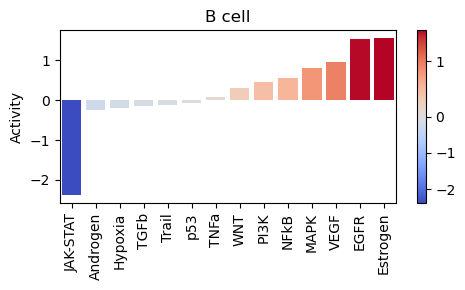

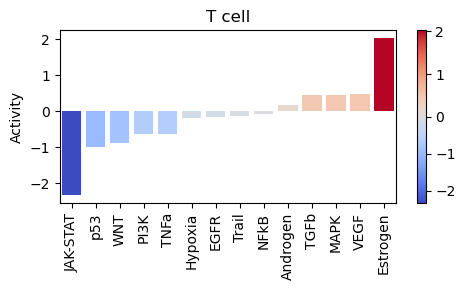

Not showing: Epithelial cell
Not showing: Macrophage/Monocyte
Not showing: Mast cell
Not showing: Plasma cell
Not showing: cDC
Not showing: Stromal
Not showing: NK cell
Not showing: Endothelial cell
Not showing: Neutrophils

Results stored in: ../../data/results/10_functional_analysis/LUAD_vs_LUSC/pathways


In [20]:
# show maximum n plots in notebook, all are saved as files
show_n = 2

for contrast in contrasts:
    print(contrast["name"])

    plt.ioff()
    p_count = 0

    for ct in contrast["cell_types"]:
        bp = dc.plot_barplot(contrast["pathway_acts"], ct, top=25, vertical=False, return_fig=True, figsize=[5, 3])
        plt.title(ct)
        plt.tight_layout()

        if bp is not None:
            ct_fname = ct.replace(" ", "_").replace("/", "_")
            aps.pl.save_fig_mfmt(
                bp,
                res_dir=f"{contrast['res_dir']}/pathways/",
                filename=f"{contrast['name']}_pw_acts_barplot_{ct_fname}",
                fmt="all",
                plot_provider="mpl",
            )
            # Only show the first two plots in the notebook
            p_count += 1
            if p_count <= show_n:
                display(bp)
            else:
                print(f"Not showing: {ct}")

            plt.close()
        else:
            print("No plot for: " + contrast["name"] + ":" + ct)

    print(f"\nResults stored in: {contrast['res_dir']}/pathways")

### Generate pathway activity heatmap

We use the seaborn `clustermap` function to generate a clustered heatmap of the celltype pathway activities and save the result in `png, pdf, svg` format.\
Signigficant activity differences are marked with "●"

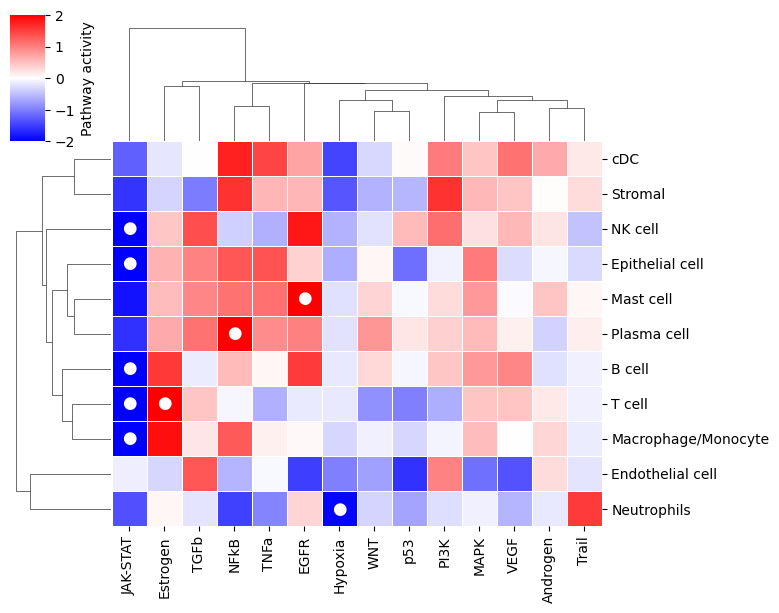


Results stored in: ../../data/results/10_functional_analysis/LUAD_vs_LUSC/pathways


In [21]:
# generate heatmap plot
for contrast in contrasts:
    # mark significant activities
    sig_mat = np.where(contrast["pathway_pvals"] < 0.05, "●", "")

    with plt.rc_context({"figure.figsize": (5.2, 5)}):
        chm = sns.clustermap(
            contrast["pathway_acts"],
            annot=sig_mat,
            annot_kws={"fontsize": 12},
            center=0,
            cmap="bwr",
            linewidth=0.5,
            cbar_kws={"label": "Pathway activity"},
            vmin=-2,
            vmax=2,
            fmt="s",
            figsize=(7, 7),
        )
        aps.pl.reshape_clustermap(chm, cell_width=0.05, cell_height=0.05)
        aps.pl.save_fig_mfmt(
            chm,
            res_dir=f"{contrast['res_dir']}/pathways/",
            filename=f"{contrast['name']}_pw_acts_heatmap",
            fmt="all",
            plot_provider="mpl",
        )
        plt.show()

        print(f"\nResults stored in: {contrast['res_dir']}/pathways")

### Generate target gene expression plots for significant pathways

We genereate expression plots for the target genes of pathways with significant activity differences using the DESeq2 `wald` statistics (y-axis) and the interaction `weight` (x-axis).\
The results are stored in `png, pdf, svg` format.

Get significant pathways

In [22]:
# filter for p-value < 0.05
for contrast in contrasts:
    p = contrast["pathway_pvals"]
    sig_pathways_idx = np.where(p < 0.05)

    # make list of celltype / pathway pairs
    sig_pathways = []

    for sig_pw in list(zip(sig_pathways_idx[0], sig_pathways_idx[1])):
        ct = p.index[sig_pw[0]]
        pw = p.columns[sig_pw[1]]
        sig_pathways.append({"ct": ct, "pw": pw})

    contrast["sig_pathways"] = sig_pathways

Generate plot

LUAD_vs_LUSC


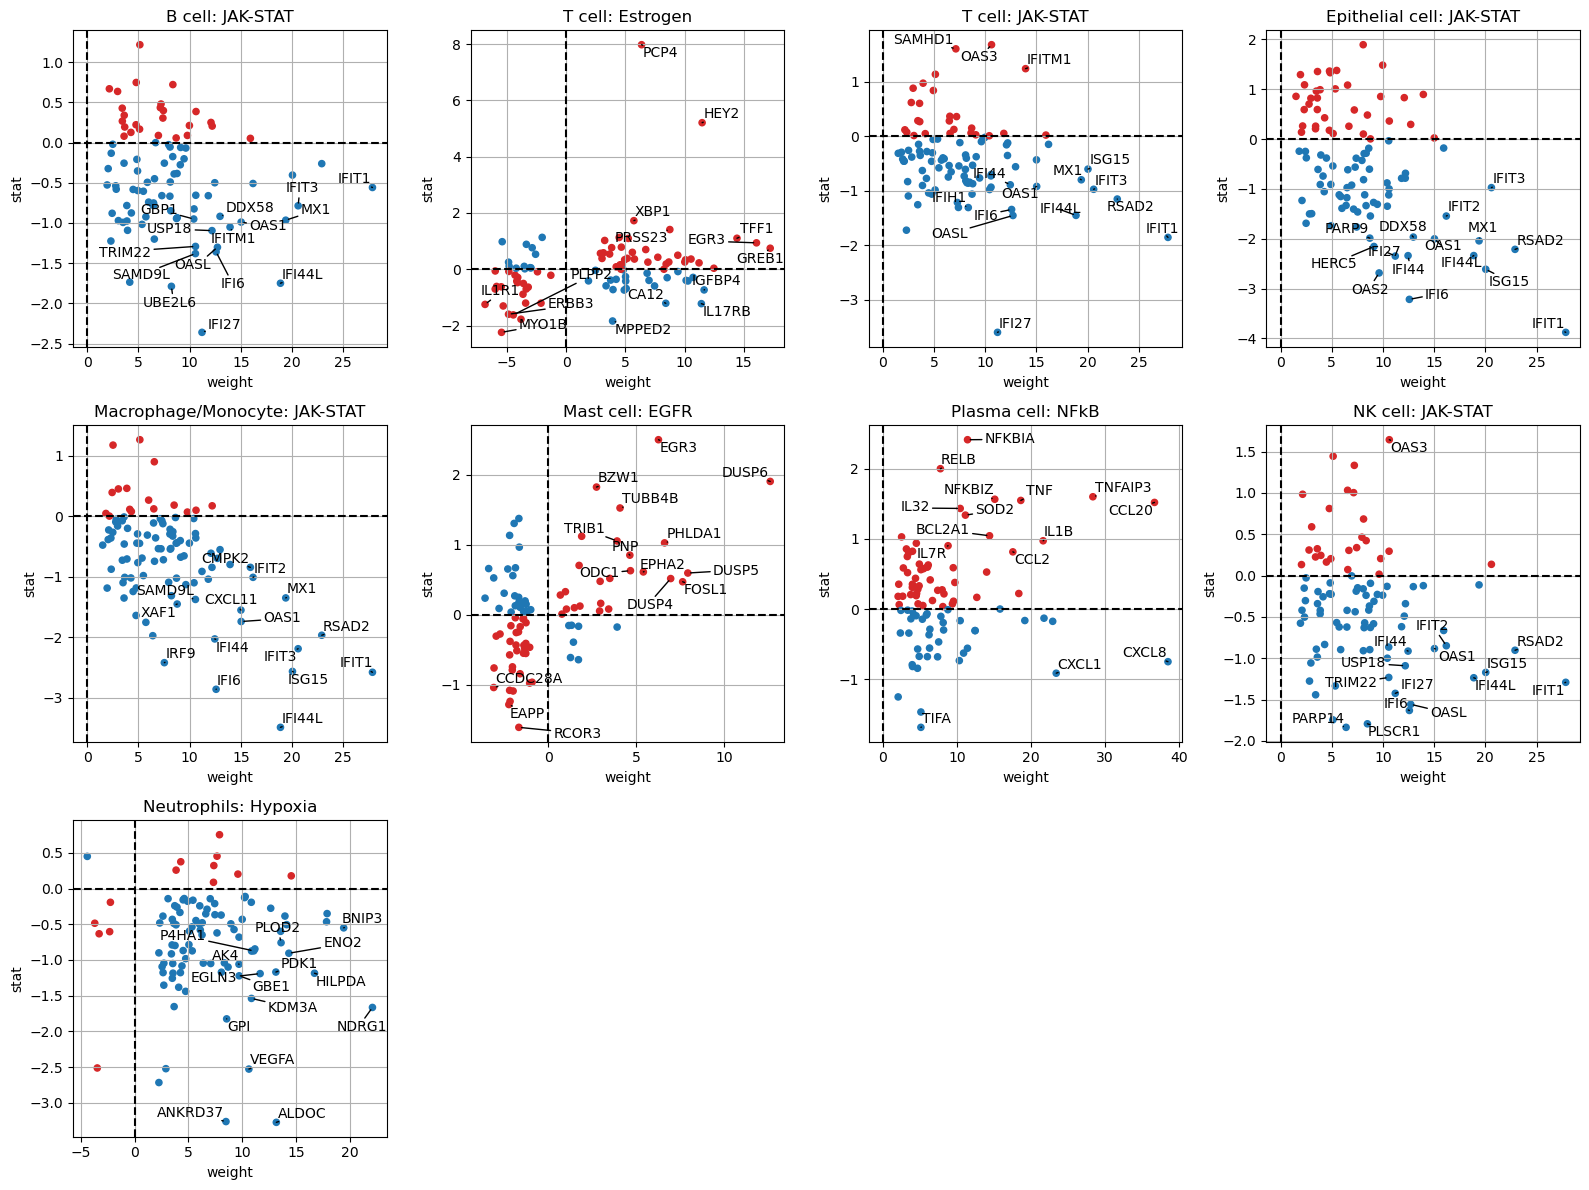


Results stored in: ../../data/results/10_functional_analysis/LUAD_vs_LUSC/pathways


In [23]:
for contrast in contrasts:
    print(contrast["name"])
    sig_pw = contrast["sig_pathways"]

    # Calculate nrows based on ncol
    n_sig = len(sig_pw)
    ncols = 4 if n_sig >= 4 else n_sig
    nrows = int(np.ceil(n_sig / ncols))

    # Initialize the figure panel
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 4))
    empty_axs = axs.flatten()
    axs = {": ".join(sig_pw.values()): {"ax": ax, "sig_pw": sig_pw} for sig_pw, ax in zip(sig_pathways, axs.flatten())}

    # Run dc.plot_targets for all significant celltype/pathway combinations using the stat values from deseq2
    for key, ax_sig_pw in axs.items():
        dc.plot_targets(
            de_res[ax_sig_pw["sig_pw"]["ct"]],
            stat="stat",
            source_name=ax_sig_pw["sig_pw"]["pw"],
            net=pwnet,
            top=15,
            return_fig=False,
            ax=ax_sig_pw["ax"],
        )
        ax_sig_pw["ax"].set_title(key)

    # set empty axes invisible
    for ax in range(len(axs), len(empty_axs)):
        empty_axs[ax].set_visible(False)

    plt.tight_layout()
    plt.show()

    # Save figure
    aps.pl.save_fig_mfmt(
        fig,
        res_dir=f"{contrast['res_dir']}/pathways/",
        filename=f"{contrast['name']}_pw_target_expression",
        fmt="all",
        plot_provider="mpl",
    )

    print(f"\nResults stored in: {contrast['res_dir']}/pathways")

### Save pathway activity and p-values matrix

Finally we store the pathway activity scores and p-values in `tsv` format.

In [24]:
# save tsv
for contrast in contrasts:
    tsv_dir = Path(contrast["res_dir"], "pathways", "tsv")
    os.makedirs(tsv_dir, mode=0o750, exist_ok=True)
    contrast["pathway_acts"].to_csv(f"{tsv_dir}/{contrast['name']}_pathway_acts.tsv", sep="\t")
    contrast["pathway_pvals"].to_csv(f"{tsv_dir}/{contrast['name']}_pathway_pvals.tsv", sep="\t")

## 6. Infer transcription factor activities with consensus

Run `decoupler` consensus method to infer transcription factor activities from the DESeq2 result using the `DoRothEA` models.\
We use the obtained gene level `wald` statistics stored in `stat`.

In [25]:
# Infer transcription factor activities with consensus
for contrast in contrasts:
    print(contrast["name"])

    tf_acts, tf_pvals = dc.run_consensus(mat=contrast["stat_mat"], net=tfnet)
    contrast["tf_acts"] = tf_acts
    contrast["tf_pvals"] = tf_pvals
    display(tf_acts)

LUAD_vs_LUSC


,AHR,AR,ARID2,ARID3A,ARNT,ASCL1,ATF1,ATF2,ATF3,ATF4,...,ZNF217,ZNF24,ZNF263,ZNF274,ZNF384,ZNF584,ZNF592,ZNF639,ZNF644,ZNF740
B cell,0.494806,-1.295860,0.635200,1.418887,-0.102753,0.079331,0.869260,0.407447,-0.171583,0.054380,...,0.229161,-0.500839,1.000176,0.400323,0.144617,-0.803722,0.255080,1.367019,0.479102,1.965370
T cell,1.016851,-1.446535,1.498919,1.636793,-0.205555,-0.167933,0.127259,-0.304117,0.396687,0.616725,...,0.362580,0.122931,0.173680,0.914766,1.057778,0.622133,1.063043,1.867058,0.635081,1.690970
Epithelial cell,0.799595,0.889566,0.614850,0.587872,-0.160495,-0.669056,1.918827,0.276528,1.026193,0.012647,...,1.058468,-1.142710,0.498508,0.835900,1.142902,-0.769006,-0.369195,0.748938,1.047694,-0.379316
Macrophage/Monocyte,0.658650,-0.061281,1.031650,1.948799,0.418177,0.480714,0.321042,1.301375,0.682869,0.072851,...,1.074232,-0.619390,0.412383,0.137358,0.958107,-0.207614,-1.124614,1.058358,0.958554,0.117008
Mast cell,0.018297,-0.362015,0.351705,1.298517,0.790630,-0.003133,0.310597,2.014739,0.951946,1.399003,...,0.150158,0.076853,1.082927,-0.271138,0.011568,-0.143134,-0.905226,1.381840,-0.294005,0.037592
Plasma cell,-0.316240,-0.512135,1.408227,0.054455,0.374182,0.277874,0.389478,2.105656,1.677759,2.472245,...,-0.287736,-0.923192,0.389007,-0.030057,-0.093641,0.177627,1.005670,2.013896,0.280040,0.210681
cDC,0.952300,-0.233354,0.193726,-0.543060,-0.542292,-0.360544,0.758698,1.044607,0.465229,0.867268,...,0.528510,0.563882,0.865910,0.903281,0.332665,0.016136,0.856794,0.305656,0.244124,-1.040939
Stromal,-0.199434,-1.809133,0.299511,0.631933,1.150875,0.046606,-0.558229,-0.047530,-0.146499,1.124005,...,-1.005617,-0.213832,1.378833,1.708246,-1.704741,-0.277866,-1.160813,-0.935735,-0.460368,-0.501042
NK cell,-0.270555,-0.804564,0.147967,0.468447,0.112973,1.337718,0.070425,-0.739791,-0.257967,0.064888,...,1.040005,0.472885,2.216977,0.026000,0.443217,0.484253,0.911762,1.514380,0.654045,2.159696
Endothelial cell,-0.549028,-0.115355,-1.938670,0.377055,-0.778608,-0.846926,0.242634,-0.825719,0.402926,-0.937721,...,-1.901210,0.404681,1.336714,-1.310807,-0.052658,-0.974488,-0.098543,0.103672,-0.702018,-0.527577


### Generate per cell type transcription factor activity barplots

We use the decoupler `plot_barplot` function for plotting the transcription factor activities of each celltype and save the result in `png, pdf, svg` format.

LUAD_vs_LUSC


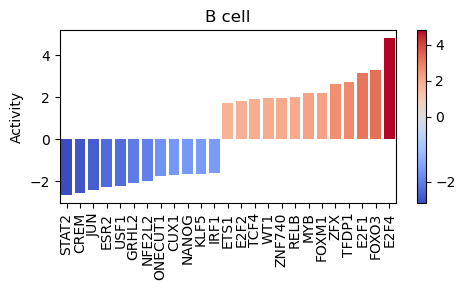

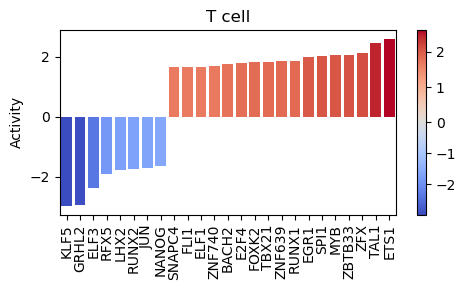

Not showing: Epithelial cell
Not showing: Macrophage/Monocyte
Not showing: Mast cell
Not showing: Plasma cell
Not showing: cDC
Not showing: Stromal
Not showing: NK cell
Not showing: Endothelial cell
Not showing: Neutrophils

Results stored in: ../../data/results/10_functional_analysis/LUAD_vs_LUSC/transcription_factors


In [26]:
# show maximum n plots in notebook, all are saved as files
show_n = 2

for contrast in contrasts:
    print(contrast["name"])

    plt.ioff()
    p_count = 0

    for ct in contrast["cell_types"]:
        bp = dc.plot_barplot(contrast["tf_acts"], ct, top=25, vertical=False, return_fig=True, figsize=[5, 3])
        plt.title(ct)
        plt.tight_layout()

        if bp is not None:
            ct_fname = ct.replace(" ", "_").replace("/", "_")
            aps.pl.save_fig_mfmt(
                bp,
                res_dir=f"{contrast['res_dir']}/transcription_factors/",
                filename=f"{contrast['name']}_tf_acts_barplot_{ct_fname}",
                fmt="all",
                plot_provider="mpl",
            )

            # Only show the first two plots in the notebook
            p_count += 1
            if p_count <= show_n:
                display(bp)
            else:
                print(f"Not showing: {ct}")

            plt.close()

        else:
            print("No plot for: " + contrast["name"] + ":" + ct)

    print(f"\nResults stored in: {contrast['res_dir']}/transcription_factors")

### Generate transcription factor activity heatmap

We use the seaborn `clustermap` function to generate a clustered heatmap of the celltype transcription factor activities and save the result in `png, pdf, svg` format.\
Signigficant activity differences are marked with "●"

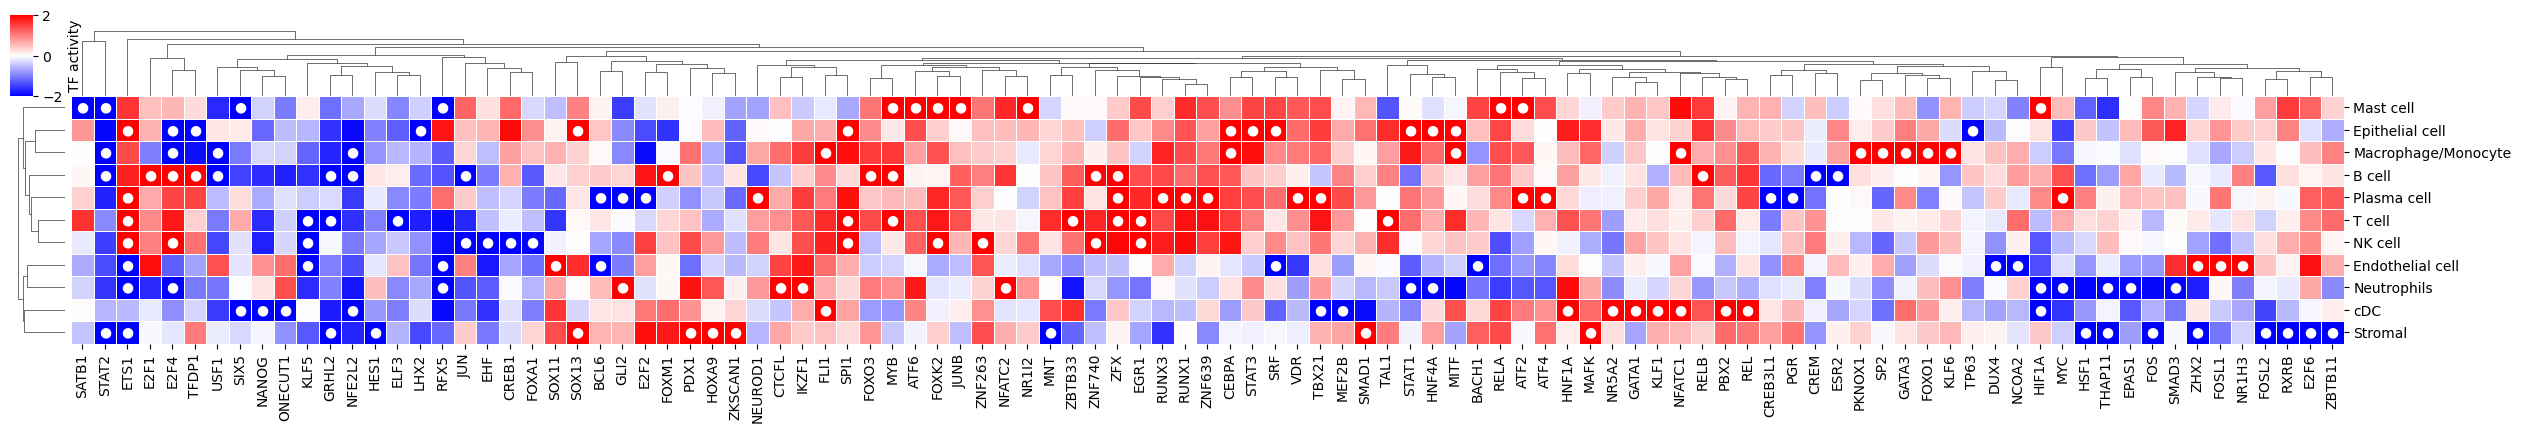


Results stored in: ../../data/results/10_functional_analysis/LUAD_vs_LUSC/transcription_factors


In [27]:
# generate heatmap plot
for contrast in contrasts:
    # get acts and pvals
    pvals = contrast["tf_pvals"].copy()
    acts = contrast["tf_acts"].copy()

    # select the columns that have significant acts (pval < 0.05)
    sig_pval_cols = pvals.columns[(pvals < 0.05).any()]

    pvals = pvals[sig_pval_cols]
    acts = acts[sig_pval_cols]

    # mark significant activities
    sig_mat = np.where(pvals < 0.05, "●", "")

    with plt.rc_context({"figure.figsize": (10, 5)}):
        chm = sns.clustermap(
            acts,
            annot=sig_mat,
            annot_kws={"fontsize": 10},
            center=0,
            cmap="bwr",
            linewidth=0.5,
            cbar_kws={"label": "TF activity"},
            vmin=-2,
            vmax=2,
            fmt="s",
            xticklabels=True,
            figsize=(4.5, 4.5),
        )
        aps.pl.reshape_clustermap(chm, cell_width=0.05, cell_height=0.05)
        aps.pl.save_fig_mfmt(
            chm,
            res_dir=f"{contrast['res_dir']}/transcription_factors/",
            filename=f"{contrast['name']}_tf_acts_heatmap",
            fmt="all",
            plot_provider="mpl",
        )
        plt.tight_layout()
        plt.show()

    print(f"\nResults stored in: {contrast['res_dir']}/transcription_factors")

### Volcano plots of expression of target genes from transcription factors of interest

We genereate volcano plots for the target genes of selected transcription factors with significant activity differences using the DESeq2 `log2foldChange` (x-axis) and `padj` (y-axis) values.\
For each transcription factor of interest a panel of celltype specific volcano plots will be created. The results are stored in `png, pdf, svg` format.

`tf_of_interest`: List of transcription factors in which we are interested and for whose target genes we want to generate a volcano plot

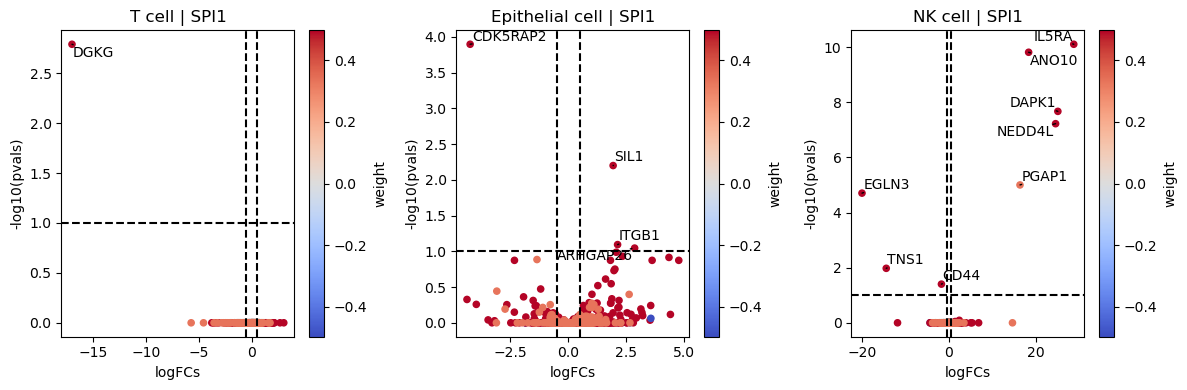

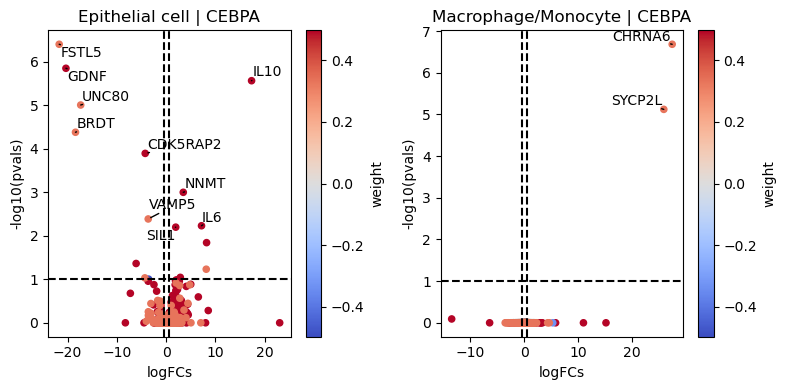

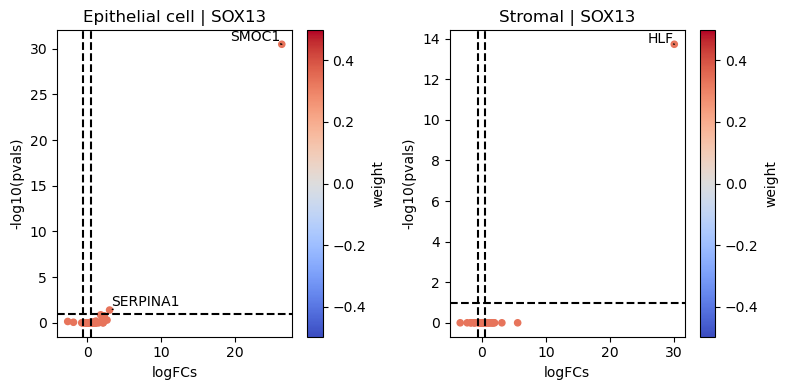


Results stored in: ../../data/results/10_functional_analysis/LUAD_vs_LUSC/transcription_factors


In [28]:
# Define transcription factors of interest
tf_of_interest = ["CEBPA", "SOX13", "SPI1"]

for contrast in contrasts:
    # Extract logFCs and pvals
    logFCs = contrast["lfc_mat"]
    pvals = contrast["fdr_mat"]
    tf_pvals = contrast["tf_pvals"]

    # get sig ct for tfoi
    n_sig = 0
    sig_tf = {}
    for ct in contrast["cell_types"]:
        for tfoi in tf_of_interest:
            if tf_pvals.loc[ct][tfoi] < 0.05:
                if tfoi not in sig_tf:
                    sig_tf[tfoi] = []
                sig_tf[tfoi].append({"ct": ct, "tf": tfoi})
                n_sig += 1

    # generate a volcano plot panel for each transcription factor of interest:
    # the panels show volcano plots for each celltype in which there is a
    # signigicant transcription factor activity
    for tf in sig_tf.keys():
        n_sig = len(sig_tf[tf])

        # Calculate nrows based on ncol
        ncols = 4 if n_sig >= 4 else n_sig
        nrows = int(np.ceil(n_sig / ncols))

        # Initialize the figure panel
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 4))
        empty_axs = axs.flatten()
        axs = [{"ct_tf": ct_tf, "ax": ax} for ct_tf, ax in zip(sig_tf[tf], axs.flatten())]

        for ax in axs:
            dc.plot_volcano(
                logFCs,
                pvals,
                ax["ct_tf"]["ct"],
                name=ax["ct_tf"]["tf"],
                net=tfnet,
                top=10,
                sign_thr=0.1,
                lFCs_thr=0.5,
                return_fig=False,
                ax=ax["ax"],
            )

        # set empty axes invisible
        for ax in range(len(axs), len(empty_axs)):
            empty_axs[ax].set_visible(False)

        plt.tight_layout()
        plt.show()

        # Save figure
        aps.pl.save_fig_mfmt(
            fig,
            res_dir=f"{contrast['res_dir']}/transcription_factors/",
            filename=f"{contrast['name']}_{tf}_target_expression",
            fmt="all",
            plot_provider="mpl",
        )

    print(f"\nResults stored in: {contrast['res_dir']}/transcription_factors")

### Save transcription factor activity and p-values matrix

Finally we store the transcription factor activity scores and p-values in `tsv` format.

In [29]:
# save tsv
for contrast in contrasts:
    tsv_dir = Path(contrast["res_dir"], "transcription_factors", "tsv")
    os.makedirs(tsv_dir, mode=0o750, exist_ok=True)
    contrast["tf_acts"].to_csv(f"{tsv_dir}/{contrast['name']}_transcription_factor_acts.tsv", sep="\t")
    contrast["tf_pvals"].to_csv(f"{tsv_dir}/{contrast['name']}_transcription_factor_pvals.tsv", sep="\t")

## 7. Infer enrichment of biological terms with GSEA using significant differential expressed genes

We can utilize MSigDB to assign biological terms to the differentially expressed genes. In this case, we will employ the `run_gsea` method from decoupler.

### Run GSEA
We use the wald statistics (`stat`) from the DESeq2 result to rank the genes.

In [30]:
for contrast in contrasts:
    # run_gsea from decoupler
    gsea_estimate, gsea_norm, gsea_pvals = dc.run_gsea(
        contrast["stat_mat"],
        msigdb,
        source="geneset",
        target="genesymbol",
        times=1000,
        batch_size=10000,
        min_n=5,
        seed=4711,
        verbose=False,
    )

    contrast["gsea_estimate"] = gsea_estimate
    contrast["gsea_norm"] = gsea_norm
    contrast["gsea_pvals"] = gsea_pvals

Now we correct for multiple hypothesis testing using BH

In [31]:
for contrast in contrasts:
    # make long format
    gsea_pvals = contrast["gsea_pvals"]
    gsea_pvals_long = pd.melt(
        gsea_pvals.T.rename_axis("source").reset_index(),
        id_vars=["source"],
        var_name="cell_type",
        value_name="pval",
    )

    # run fdrcorrection and add padj to df
    gsea_pvals_long["padj"] = statsmodels.stats.multitest.fdrcorrection(gsea_pvals_long["pval"].values)[1]

    # make padj_mat
    gsea_padj = gsea_pvals_long.pivot(index="cell_type", columns="source", values="padj")
    gsea_padj.index.name = None

    # store the padj for the contrast and make sure that we preserve the order of row and columns
    contrast["gsea_padj"] = gsea_padj.reindex(index=contrast["gsea_pvals"].index).reindex(
        contrast["gsea_pvals"].columns, axis=1
    )

### Generate MSigDB heatmap from GSEA normalized enrichment scores

We use the seaborn `heatmap` function to generate a heatmap of the biological terms assigned by GSEA to the different celltypes and save the result in `png, pdf, svg` format.\
Signigficantly overrepresented terms are marked with "●"
* NES (normalized enrichment score) is color-coded

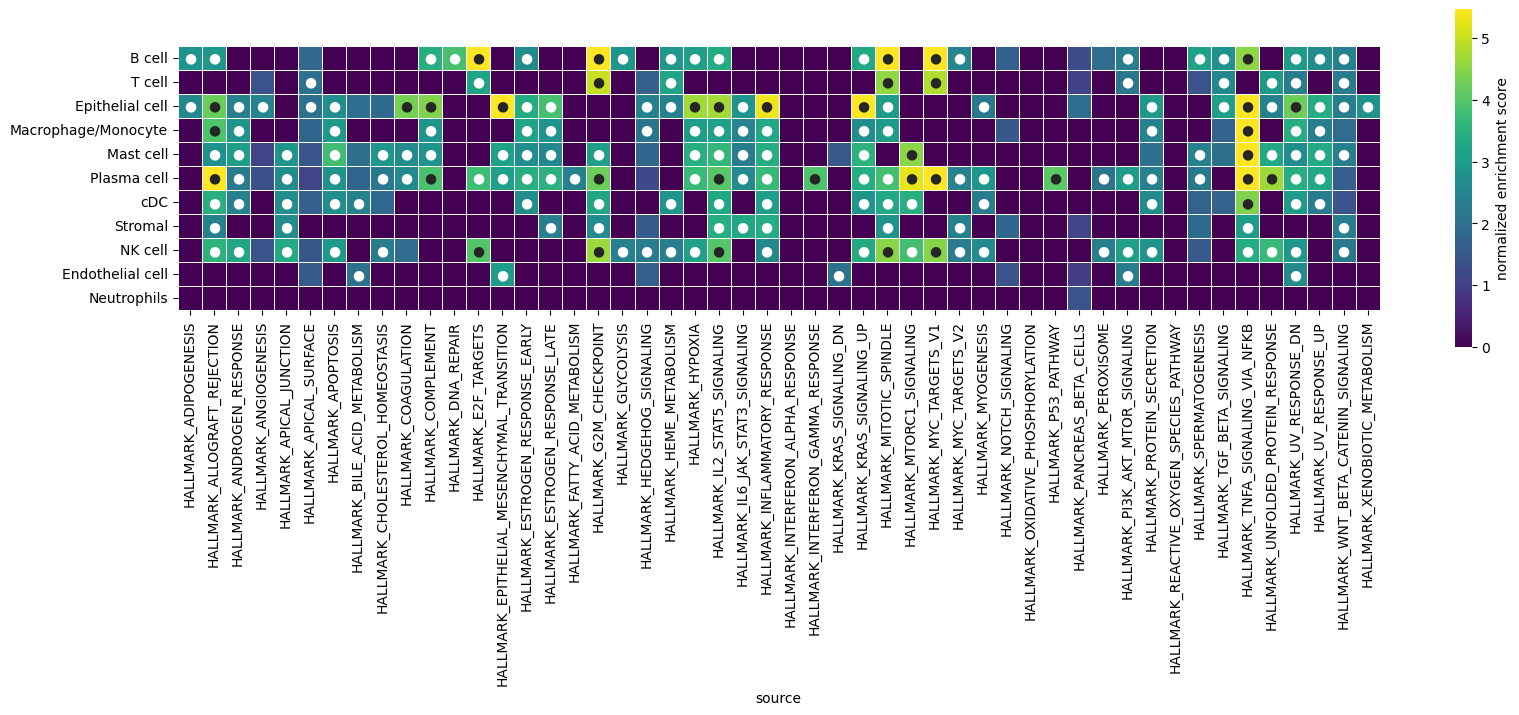


Results stored in: ../../data/results/10_functional_analysis/LUAD_vs_LUSC/MSigDB


In [32]:
# Plot heatmap of GSEA result
for contrast in contrasts:
    gsea_padj = contrast["gsea_padj"]

    gsea_norm = contrast["gsea_norm"].copy()

    # filter for enriched (positve nes score)
    gsea_norm[gsea_norm < 0] = 0

    # mark significant enrichment
    sig_mat = np.where(gsea_padj[gsea_norm > 0] < 0.05, "●", "")

    # create figure
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(17, 10))

    # create heatmap
    hm = sns.heatmap(
        gsea_norm,
        annot=sig_mat,
        robust=True,
        cmap="viridis",
        linewidth=0.5,
        cbar=True,
        cbar_kws={"label": "normalized enrichment score", "shrink": 0.4},
        fmt="s",
        square=True,
        xticklabels=True,
        ax=ax,
    )
    plt.tight_layout()
    aps.pl.save_fig_mfmt(
        fig,
        res_dir=f"{contrast['res_dir']}/MSigDB/",
        filename=f"{contrast['name']}_MSigDB_GSEA_heatmap",
        fmt="all",
        plot_provider="mpl",
    )
    plt.show()

    print(f"\nResults stored in: {contrast['res_dir']}/MSigDB")

### Visualize the most enriched terms as barplot

We use the decoupler `plot_barplot` function to generate barplots of the most enriched biological and save the result in `png, pdf, svg` format.
* `top_n`: top n cell types to generate barplots for. Cell types are sorted by the highest GSEA score

In [33]:
top_n = 4

# show top n celltypes
for contrast in contrasts:
    print(contrast["name"] + "\n")
    display(np.max(contrast["gsea_norm"].T).sort_values().tail(top_n))
    display(np.min(contrast["gsea_padj"].T).sort_values().head(top_n))

LUAD_vs_LUSC



Macrophage/Monocyte    5.980028
Mast cell              6.528894
Epithelial cell        7.056918
B cell                 8.231769
dtype: float32

B cell             9.453365e-14
Neutrophils        6.443057e-11
Epithelial cell    2.340751e-10
Mast cell          5.205902e-09
dtype: float64

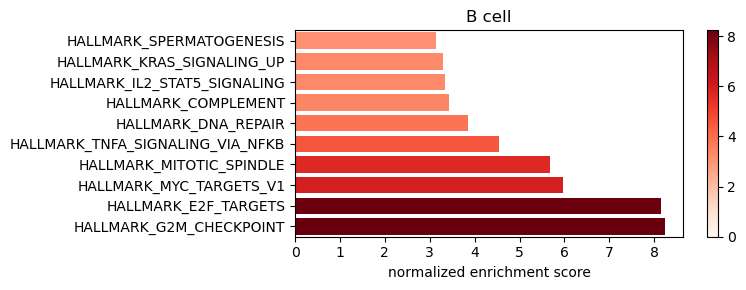

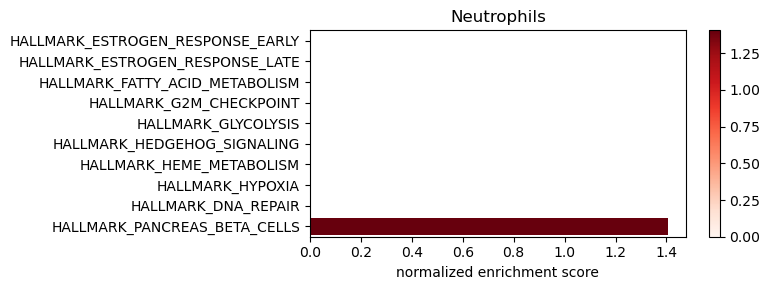

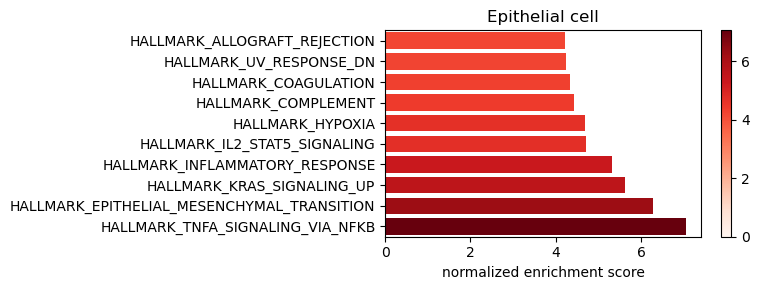

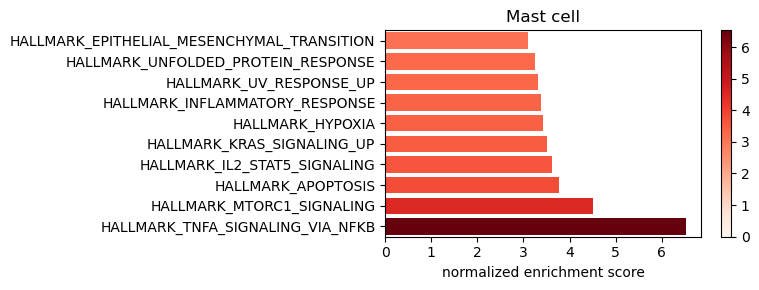


Results stored in: ../../data/results/10_functional_analysis/LUAD_vs_LUSC/MSigDB


In [34]:
for contrast in contrasts:
    gsea_norm = contrast["gsea_norm"].copy()

    # filter for enriched (positve nes score)
    gsea_norm[gsea_norm < 0] = 0

    # get top n celltypes
    top_celltypes = np.min(gsea_padj.T).sort_values().head(top_n).index.values

    with plt.rc_context({"figure.figsize": (8, 3)}):
        for ct in top_celltypes:
            vcenter = np.max(gsea_norm.T[ct]) / 2
            bp = dc.plot_barplot(
                gsea_norm,
                ct,
                top=10,
                vertical=True,
                return_fig=True,
                vmin=0,
                vcenter=vcenter,
                cmap="Reds",
                figsize=[8, 3],
            )
            plt.title(ct)
            plt.xlabel("normalized enrichment score")
            plt.tight_layout()
            plt.show()

            if bp is not None:
                ct_fname = ct.replace(" ", "_").replace("/", "_")
                aps.pl.save_fig_mfmt(
                    bp,
                    res_dir=f"{contrast['res_dir']}/MSigDB/",
                    filename=f"{contrast['name']}_top_terms_barplot_{ct_fname}",
                    fmt="all",
                    plot_provider="mpl",
                )
            else:
                print("No plot for: " + contrast["name"] + ":" + ct)
    plt.close()

    print(f"\nResults stored in: {contrast['res_dir']}/MSigDB")

### Generate volcano plots for the most enriched term of the top n celltypes

* `top_n`: number of celltypes to generate volcano plot of the most enriched term

In [35]:
top_n = 6

In [36]:
# show top n celltypes
np.max(contrast["gsea_norm"].T).sort_values().tail(top_n)

T cell                 5.009815
Plasma cell            5.603541
Macrophage/Monocyte    5.980028
Mast cell              6.528894
Epithelial cell        7.056918
B cell                 8.231769
dtype: float32

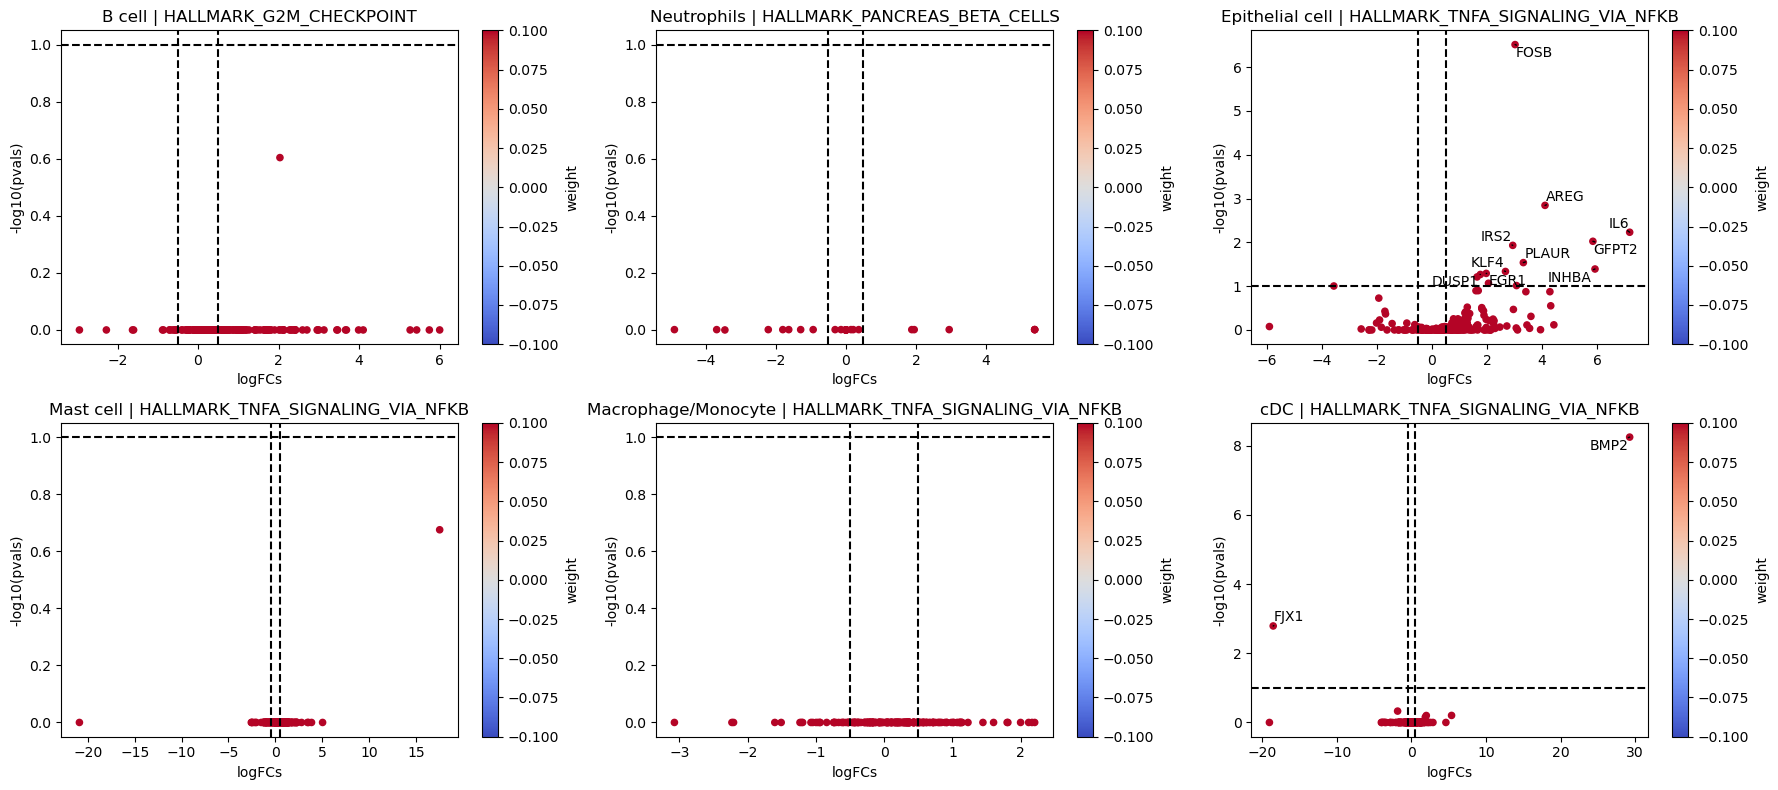


Results stored in: ../../data/results/10_functional_analysis/LUAD_vs_LUSC/MSigDB


In [37]:
for contrast in contrasts:
    logFC = contrast["lfc_mat"]
    pvals = contrast["fdr_mat"]

    # get top n celltypes
    top_celltypes = np.min(contrast["gsea_padj"].T).sort_values().head(top_n).index.values

    # get top term of each celltype
    top_term = {}
    for ct in top_celltypes:
        top_term[ct] = contrast["gsea_norm"].loc[ct].idxmax()

    # Calculate nrows based on ncol
    ncols = 3 if top_n >= 3 else n_sig
    nrows = int(np.ceil(top_n / ncols))

    # Initialize the figure panel
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 6, nrows * 4))
    empty_axs = axs.flatten()
    axs = [[{"ct": t, "term": top_term[t]}, ax] for t, ax in zip(top_term, axs.flatten())]

    for t, ax in axs:
        dc.plot_volcano(
            logFCs,
            pvals,
            t["ct"],
            name=t["term"],
            net=msigdb,
            top=10,
            sign_thr=0.1,
            lFCs_thr=0.5,
            source="geneset",
            target="genesymbol",
            weight=None,
            return_fig=False,
            ax=ax,
        )

    # set empty axes invisible
    for ax in range(len(axs), len(empty_axs)):
        empty_axs[ax].set_visible(False)

    plt.tight_layout()
    plt.show()

    # Save figure
    aps.pl.save_fig_mfmt(
        fig,
        res_dir=f"{contrast['res_dir']}/MSigDB/",
        filename=f"{contrast['name']}_top_terms_target_expression",
        fmt="all",
        plot_provider="mpl",
    )

    print(f"\nResults stored in: {contrast['res_dir']}/MSigDB")

### Save GSEA scores of enriched terms

Finally we store the GSEA scores of enriched terms in `tsv` format.

In [38]:
# save tsv
for contrast in contrasts:
    tsv_dir = Path(contrast["res_dir"], "MSigDB", "tsv")
    os.makedirs(tsv_dir, mode=0o750, exist_ok=True)
    contrast["gsea_norm"].to_csv(f"{tsv_dir}/{contrast['name']}_MSigDB_GSEA_nes.tsv", sep="\t")
    contrast["gsea_estimate"].to_csv(f"{tsv_dir}/{contrast['name']}_MSigDB_GSEA_estimate.tsv", sep="\t")
    contrast["gsea_pvals"].to_csv(f"{tsv_dir}/{contrast['name']}_MSigDB_GSEA_pvals.tsv", sep="\t")
    contrast["gsea_padj"].to_csv(f"{tsv_dir}/{contrast['name']}_MSigDB_GSEA_padj.tsv", sep="\t")

## 8. CytoSig analysis

We define enriched cytokine signaling signatures in the tumor cells using the *CytoSig* signature matrix an the `decoupler` consesus scoring function.

First we reformat the signature matrix into long format

In [39]:
# reformat the signature matrix
cyto_sig = pd.melt(
    cytosig_signature.rename_axis("target").reset_index(), var_name="source", id_vars=["target"], value_name="weight"
).reindex(columns=["source", "target", "weight"])
cyto_sig

,source,target,weight
0,Activin A,A2M,0.050964
1,Activin A,A4GALT,-0.208403
2,Activin A,AAAS,-0.026028
3,Activin A,AACS,-0.107110
4,Activin A,AAK1,-0.022077
...,...,...,...
329761,WNT3A,ZZZ3,0.027164
329762,WNT3A,CHN2,-0.064087
329763,WNT3A,ESRRG,0.042413
329764,WNT3A,FHIT,-0.046138


Run the decoupler consensus scoring function using the DESeq2 `wald` statistics and the `CytoSig` net

In [40]:
# Infer cytokin signaling with consensus
for contrast in contrasts:
    print(contrast["name"])

    cs_acts, cs_pvals = dc.run_consensus(mat=contrast["stat_mat"], net=cyto_sig)
    contrast["cs_acts"] = cs_acts
    contrast["cs_pvals"] = cs_pvals
    display(cs_acts)

LUAD_vs_LUSC


,Activin A,BDNF,BMP2,BMP4,BMP6,CD40L,CXCL12,EGF,FGF2,GCSF,...,PGE2,TGFA,TGFB1,TGFB2,TGFB3,TNFA,TRAIL,TWEAK,VEGFA,WNT3A
B cell,-0.482645,2.259696,-0.863617,-1.478322,0.045382,-0.587955,-1.131240,0.708744,-2.260389,0.762260,...,0.096722,0.382647,-0.597529,1.654241,-1.672500,0.085604,-0.374362,-0.116501,0.441779,0.904713
T cell,0.140575,1.639996,-0.324083,-0.616470,-0.592388,0.268146,-0.642872,1.222686,-0.956480,-0.371912,...,0.765180,0.291763,0.594389,1.611181,1.894272,0.106447,0.613308,0.675075,0.567940,0.762486
Epithelial cell,0.272666,0.784764,0.310925,1.235774,-0.914101,1.092303,0.749393,0.998541,0.405041,0.557433,...,1.420431,0.623688,1.169039,0.339757,2.496500,0.739315,0.873977,0.676544,0.679720,0.279122
Macrophage/Monocyte,0.041470,0.338627,0.317325,0.641721,0.309349,1.157407,0.188017,1.147379,0.363294,1.282793,...,0.391389,0.514752,0.716912,0.610758,1.851552,0.948504,0.728291,0.287427,1.120714,0.509944
Mast cell,-0.096104,0.772115,-0.267422,0.273003,-0.017583,1.223186,0.569612,1.404026,0.896433,0.931618,...,0.340526,1.117030,0.683753,0.585125,0.333965,0.926995,1.497205,-0.190361,2.420311,-0.224755
Plasma cell,0.256896,0.878637,0.040202,-0.118374,-0.959250,0.492737,0.818972,1.345826,-0.165030,0.694331,...,0.916952,1.382699,0.226926,1.535076,1.177694,1.292434,0.997565,0.339793,1.494568,0.082869
cDC,-0.167750,-0.032823,0.477761,0.674290,0.665357,2.155193,0.137226,0.423279,-0.292649,0.860476,...,0.159508,0.462986,0.766819,0.040337,1.995206,1.628578,1.295601,0.865028,0.308940,0.840638
Stromal,-0.200348,-0.317472,-0.636725,-1.060266,0.785712,1.281653,0.419830,-0.099255,0.321945,0.117448,...,0.444467,-1.360930,-0.758920,-1.296940,-0.953828,0.372752,2.755995,-0.088483,-0.576638,-0.388535
NK cell,0.579675,1.941291,0.323328,-0.651687,0.393145,0.514874,0.541557,0.720228,-1.358832,0.430221,...,1.045959,0.888556,0.256206,0.933542,1.715605,1.100328,0.643063,1.301733,0.427909,0.206403
Endothelial cell,-0.140653,-1.391896,0.178591,0.526312,1.052298,0.599148,-0.009525,-1.536899,0.367362,0.183483,...,-0.882414,-0.814086,0.080818,-0.311397,0.818802,0.118420,0.831849,-0.907669,-0.890997,1.998672


### Generate signaling activity heatmap

We use the seaborn `clustermap` function to generate a clustered heatmap of the celltype signaling activities and save the result in `png, pdf, svg` format.\
Signigficant signaling activity differences are marked with "●"

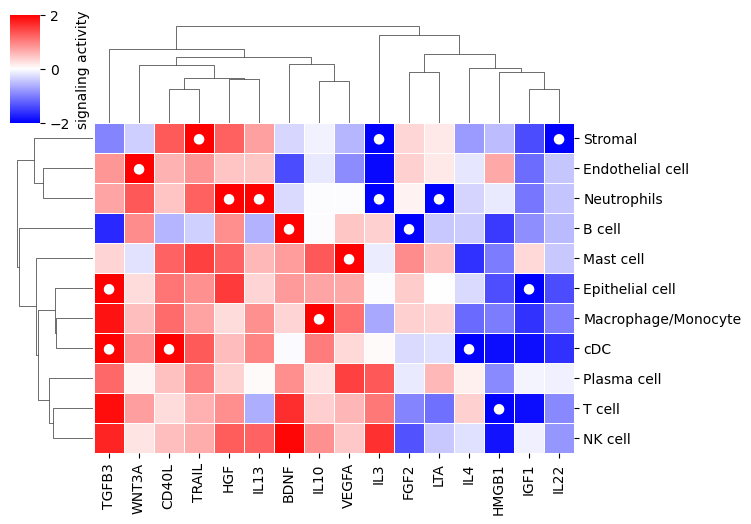


Results stored in: ../../data/results/10_functional_analysis/LUAD_vs_LUSC/cytokine_signaling


In [41]:
# generate heatmap plot
for contrast in contrasts:
    # get acts and pvals
    pvals = contrast["cs_pvals"].copy()
    acts = contrast["cs_acts"].copy()

    # select the columns that have significant acts (pval < 0.05)
    sig_pval_cols = pvals.columns[(pvals < 0.05).any()]

    pvals = pvals[sig_pval_cols]
    acts = acts[sig_pval_cols]

    # mark significant activities
    sig_mat = np.where(pvals < 0.05, "●", "")

    with plt.rc_context({"figure.figsize": (10, 10)}):
        chm = sns.clustermap(
            acts,
            annot=sig_mat,
            annot_kws={"fontsize": 10},
            center=0,
            cmap="bwr",
            linewidth=0.5,
            cbar_kws={"label": "signaling activity"},
            vmin=-2,
            vmax=2,
            fmt="s",
            xticklabels=True,
            figsize=(6, 6),
        )
        aps.pl.reshape_clustermap(chm, cell_width=0.05, cell_height=0.05)
        aps.pl.save_fig_mfmt(
            chm,
            res_dir=f"{contrast['res_dir']}/cytokine_signaling/",
            filename=f"{contrast['name']}_signaling_heatmap",
            fmt="all",
            plot_provider="mpl",
        )
        plt.show()

        print(f"\nResults stored in: {contrast['res_dir']}/cytokine_signaling")

### Save cytokine signaling activity scores and p-values matrix

Finally we store the cytokine signaling activity scores and p-values in `tsv` format.

In [42]:
# save tsv
for contrast in contrasts:
    tsv_dir = Path(contrast["res_dir"], "cytokine_signaling", "tsv")
    os.makedirs(tsv_dir, mode=0o750, exist_ok=True)
    contrast["cs_acts"].to_csv(f"{tsv_dir}/{contrast['name']}_CytoSig_acts.tsv", sep="\t")
    contrast["cs_pvals"].to_csv(f"{tsv_dir}/{contrast['name']}_CytoSig_pvals.tsv", sep="\t")